In [1]:
import re
import urllib.request
import urllib.parse
import html
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd
from kiwipiepy.utils import Stopwords
from kiwipiepy import Kiwi
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from konlpy.tag import Okt
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

In [5]:
cd py-hanspell-master

/Users/park/Desktop/text_data/project/py-hanspell-master


In [6]:
!python setup.py install

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/setuptools/dist.py:472: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        By 2024-Sep-26, you need to update your project and remove deprecated calls
        or your builds will no longer be supported.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
running install
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        *****************************

# 데이터 수집

In [2]:
# HTML 태그 제거 함수
def remove_tag(my_str):
    p = re.compile('(<([^>]+)>)')
    return p.sub('', my_str)

# Naver API client_id, client_secret 설정
client_id = 'YpmSpxkmEjMIOOcNRup0'
client_secret = 'PaW25JfyJW'

# WebDriver 설정 (크롬 드라이버 사용)
driver = webdriver.Chrome()

# 검색할 query 리스트
queries = ['부산여행', '여수여행', '제주여행', '강릉여행', '경주여행', '가평여행', '광주여행', '춘천여행']
n_display = 100  # 한 번에 추출할 결과 개수
sort = 'sim'  # 결과 정렬 방식

all_results = []  # 모든 결과를 저장할 리스트

# 각 query에 대해 1000개씩 데이터를 추출
for query in queries:
    encQuery = urllib.parse.quote(query)
    
    # 블로그 검색 크롤링
    start = 1
    while start <= 1000:
        url = f'{base_url_blog}?query={encQuery}&display={n_display}&start={start}&sort={sort}'
        my_request = urllib.request.Request(url)
        my_request.add_header("X-Naver-Client-Id", client_id)
        my_request.add_header("X-Naver-Client-Secret", client_secret)
        response = urllib.request.urlopen(my_request)
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read()
        else:
            print("Error Code:" + rescode)
            continue
        
        search_results = response_body.decode('utf-8')
        search_results = eval(search_results)
        
        for item in search_results['items']:
            link = html.unescape(item['link']).replace('\\', '')
            postdate = item.get('postdate', 'Unknown')  # 'postdate' 필드 사용
            title = remove_tag(item['title'])  # HTML 태그 제거
            content = remove_tag(item['description'])  # HTML 태그 제거
            all_results.append({
                'source': 'blog',
                'query': query,
                'url': link,
                'postdate': postdate,
                'title': title,
                'content': content
            })
        start += 100
        time.sleep(1)  # 1초 대기

    # 카페 검색 크롤링
    start = 1
    while start <= 1000:
        url = f'{base_url_cafe}?query={encQuery}&display={n_display}&start={start}&sort={sort}'
        my_request = urllib.request.Request(url)
        my_request.add_header("X-Naver-Client-Id", client_id)
        my_request.add_header("X-Naver-Client-Secret", client_secret)
        response = urllib.request.urlopen(my_request)
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read()
        else:
            print("Error Code:" + rescode)
            continue
        
        search_results = response_body.decode('utf-8')
        search_results = eval(search_results)
        
        for item in search_results['items']:
            link = html.unescape(item['link']).replace('\\', '')
            postdate = item.get('cafewrite', 'Unknown')  # 'cafewrite' 필드 사용
            title = remove_tag(item['title'])  # HTML 태그 제거
            content = remove_tag(item['description'])  # HTML 태그 제거
            all_results.append({
                'source': 'cafe',
                'query': query,
                'url': link,
                'postdate': postdate,
                'title': title,
                'content': content
            })
        start += 100
        time.sleep(1)  # 1초 대기

# 드라이버 종료
driver.quit()

# 결과를 DataFrame으로 변환
df_all_results = pd.DataFrame(all_results)

# 중복 제거
df_travel = df_all_results.drop_duplicates(subset=['content'], keep='first', inplace=False).reset_index(drop=True)

# 리스트 타입인 content 제거
idx_lst = []
for idx, i in enumerate(df_travel['content']):
    if type(i) == list:
        idx_lst.append(idx)
df_travel.drop(index=idx_lst, inplace=True)

# 결측치 제거
df_travel.dropna(inplace=True)

# 데이터 전처리

In [3]:
df_travel = pd.read_csv('text_data_project.csv')

In [4]:
df_travel

source query                                             url  postdate  \
0       blog  부산여행     https://blog.naver.com/ksysysy/223430183686  20240429   
1       blog  부산여행    https://blog.naver.com/mimo0320/223440010599  20240508   
2       blog  부산여행   https://blog.naver.com/ssong6604/223420223279  20240419   
3       blog  부산여행    https://blog.naver.com/cucuya21/223431544945  20240430   
4       blog  부산여행  https://blog.naver.com/danbii1004/223443985093  20240512   
...      ...   ...                                             ...       ...   
15835   cafe  춘천여행            http://cafe.naver.com/haruhi/2619008   Unknown   
15836   cafe  춘천여행              http://cafe.naver.com/maian/113372   Unknown   
15837   cafe  춘천여행            http://cafe.naver.com/naganda/352379   Unknown   
15838   cafe  춘천여행         http://cafe.naver.com/mindy7857/3060441   Unknown   
15839   cafe  춘천여행            http://cafe.naver.com/old4567/168005   Unknown   

                                       title  \
0             [부산 여행] Day 1. 부평깡통시장 야시장 먹거리.   
1                     부산여행  2박3일 가족여행 코스 총정리   
2                   부산여행, 모모스커피 로스터리&amp;커피바   
3           부산가볼만한곳,부산여행1박2일 해운대 해수욕장 해변...    
4      2024 부산여행 # 8 - 아난티 앳 부산 ( 맥퀸즈라운지...    
...                                      ...   
15835                            춘천여행 도와주세요.   
15836                춘천 호텔 벤틀리 아고다 할인코드 예약팁!   
15837                    차 없이 춘천 여행코스 부탁드려요~   
15838                            여행#1)춘천 공지천   
15839                  [여행]춘천 가볼만한 곳 BEST 추천   

                                                 content  
0      즉흥적으로 부산여행을 다녀오게되었는데 2박 3일의 여행 중에 깡통시장을 3일 내내 ...  
1      5월5일 어린이날 기념으로 고고써니 4인가족 부산여행 다녀왔어요 부산에 친한언니가 ...  
2      그래서 또 부산에 오면 굳이 또 올일은 없겠구나 생각했어요 사진속에 봤던 뷰는 좋았...  
3      미팅과 강의가 연속된 부산 일정이었지만 KTX로 이동하고 해운대 해수욕장 주변에 숙...  
4      3박4일 부산여행의 흔적들(스벅텀블러는 구입한날 트렁크에 던져놓고 꺼내질 않아 사진...  
...                                                  ...  
15835  작년에 가평엘가서 남이섬, 프로방스, 에니메이션 박물관을 둘러보구 왔는데 혹시 현지...  
15836  음식점과 카페가 있어 춘천의 미식을 경험하기에 좋습니다. 호텔 벤틀리 춘천은 비즈니...  
15837  차 없이 춘천 여행을 가려고 합니다. 서울에서 출발하고, 1박2일 생각하고 있습니다...  
15838  춘천 갈때마다 빼놓지 않고 들리는 곳이 바로 공지천이에요~ 이번에도 안가면 서운하니...  
15839  춘천 의암호 일출 https:\/\/blog.naver.com\/b1106b\/22...  

[15840 rows x 6 columns]

In [7]:
# konlpy 모듈 경로 확인
konlpy_path = os.path.dirname(konlpy.__file__)
print(f"konlpy 경로: {konlpy_path}")

# 작업 디렉토리를 konlpy java 디렉토리로 변경
java_dir = os.path.join(konlpy_path, 'java')
os.chdir(java_dir)
print(f"Current working directory: {os.getcwd()}")

# data 파일 경로 설정
file_path = os.path.join(java_dir, 'org/openkoreantext/processor/util/noun/names.txt')

# 기존 데이터 읽기
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        data = f.read()
else:
    data = ""
    print(f"{file_path} does not exist. A new file will be created.")

# 새 단어 추가
new_words = [
    '양떼목장', '수박', '서울근교', '풀빌라', '아난티', '아침고요수목원', '오색별빛정원','카라반캠핑''카이베이호텔', '아르떼뮤지엄', '경포해변', '초당순두부','짬뽕순두부','순두부젤라또','동화가든','하슬라아트월드', '솔향수목원','황리단길', '보문단지', '대릉원', '노벨라', '천년의숲','버드파크','광주공원',
    '챔피언스필드', '김대중컨벤션센터', '궁전제과', '밤양갱','국립문화전당','민주화운동'
    '광안리', '요트투어', '해변열차', '조개구이','부산타워','밀락더마켓'
    '이순신광장', '루지테마파크', '풀빌라', '라마다호텔', '해상케이블카', '생선구이', '갈치조림', '라테라스', '거북선축제', '벽화마을',
    '신화월드', '제주공항', '에이코스', '동화마을', '신라호텔','함덕해수욕장'
    '스카이워크', '제이드가든', '풍물시장', '애견동반', '잭슨나인스호텔', '오월학교', '해피초원목장','동궁과월지'
]

data += '\n' + '\n'.join(new_words) + '\n'

# 사전 저장
with open(file_path, 'w') as f:
    f.write(data)

# 저장된 데이터 출력
print(data)


konlpy 경로: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/konlpy
Current working directory: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/konlpy/java
가몽
가온
갓세븐
강새이
게임닉가
관우
귀여미
규
김유이
김준면
까까런
노컷
누너예
니노
다마고치
다이무스
대학생
데이브
도요토미
동운
동이
두주니
디시인사이드
디오
라몹
라스
라옵
멍구
메이든
명덕
명량
문민정부
미네
방엘리
병헌
붓다
비정상회담
빼빼로
삼풍
샤인온미
성식
성열
세라문
세라복
세종대왕
손권
손책
쇼미더머니
쇼챔
순규
스라소니
신동아
신쓰패밀리
신아라
아베
안상홍
안홍준
여누
여랑
여포
연합
오꾸닭
요섭
웃찾사
원식
유병언
유비
유이
윤기형
이나단
이명박
이완용
임창용
자괴
자니윤
자대련
자유
재중이
전교조
정윤회
제갈량
조자룡
조조
준면
지오디
지존파
진영오
차작가
차트
창섭
챠트
첸
코르사주
하무열
하용파쿠
혁재
현이
현태
혜미

양떼목장
수박
서울근교
풀빌라
아난티
아침고요수목원
오색별빛정원
스카이베이호텔
아르떼뮤지엄
경포해변
초당순두부
황리단길
보문단지
대릉원
노벨라
천년의숲
챔피언스필드
김대중컨벤션센터
궁전제과
밤양갱
광안리
요트투어
해변열차
조개구이
이순신광장
루지테마파크
풀빌라
라마다호텔
해상케이블카
생선구이
갈치조림
라테라스
거북선축제
신화월드
제주공항
에이코스
동화마을
신라호텔
스카이워크
제이드가든
풍물시장
애견동반
잭슨나인스호텔
오월학교
해피초원목장
동궁과 월지

양떼목장
수박
서울근교
풀빌라
아난티
아침고요수목원
오색별빛정원
카라반캠핑카이베이호텔
아르떼뮤지엄
경포해변
초당순두부
짬뽕순두부
순두부젤라또
동화가든
하슬라아트월드
솔향수목원
황리단길
보문단지
대릉원
노벨라
천년의숲
버드파크
광주공원
챔피언스필드
김대중컨벤션센터
궁전제과
밤양갱
국립문화

In [8]:
# KoNLPy의 형태소 분석기 객체 생성
okt = Okt()

# 이모티콘 및 반복 문자열 제거를 위한 정규식 패턴
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
repeat_pattern = re.compile(r'(.)\1{1,}', re.IGNORECASE)

# 불용어 파일 읽기
with open('/Users/park/Desktop/text_data/project/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def preprocess(text):
    # 이모티콘 제거
    text = emoji_pattern.sub(r'', text)
    
    # 반복되는 문자열 제거
    text = repeat_pattern.sub(r'\1', text)
    
    # 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    
    # 형태소 분석 및 품사 태깅
    pos_tags = okt.pos(text, norm=True, stem=True)
    
    # 명사만 추출하여 불용어 제거
    tokens = [word[0] for word in pos_tags if word[1] in ['Noun'] and word[0] not in stopwords]
    
    return tokens


# 'content' 열이 존재하는 데이터프레임에 대해 전처리 함수를 적용하여 새로운 열에 저장
df_travel['content'] = df_travel['content'].astype(str)
df_travel['tokens'] = df_travel['content'].apply(preprocess)

# 결과를 CSV 파일로 저장
df_travel.to_csv('text_data_project_tokens_2.csv', index=False, encoding='utf-8')


In [9]:
df_travel_tokens = pd.read_csv('text_data_project_tokens_2.csv')

# WordCloud

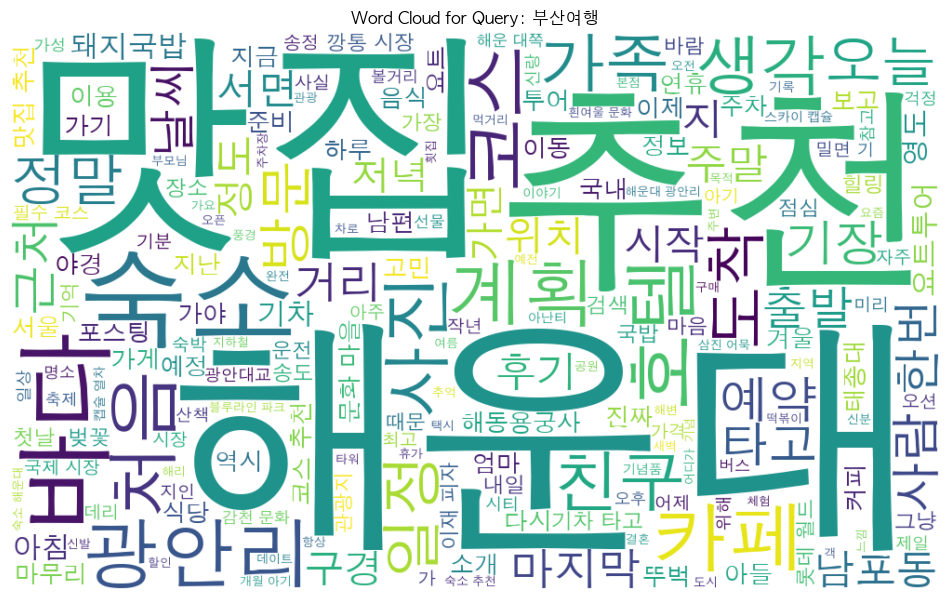

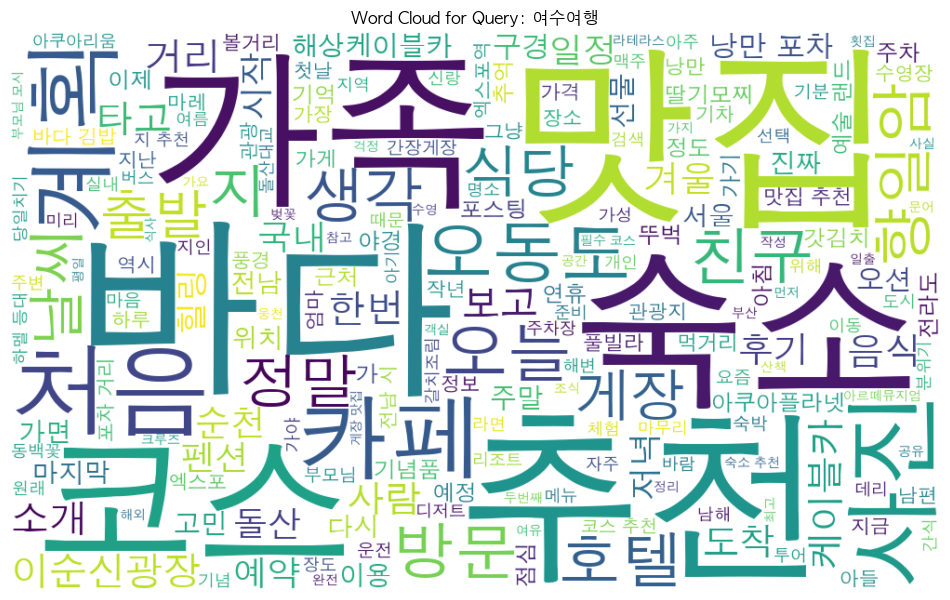

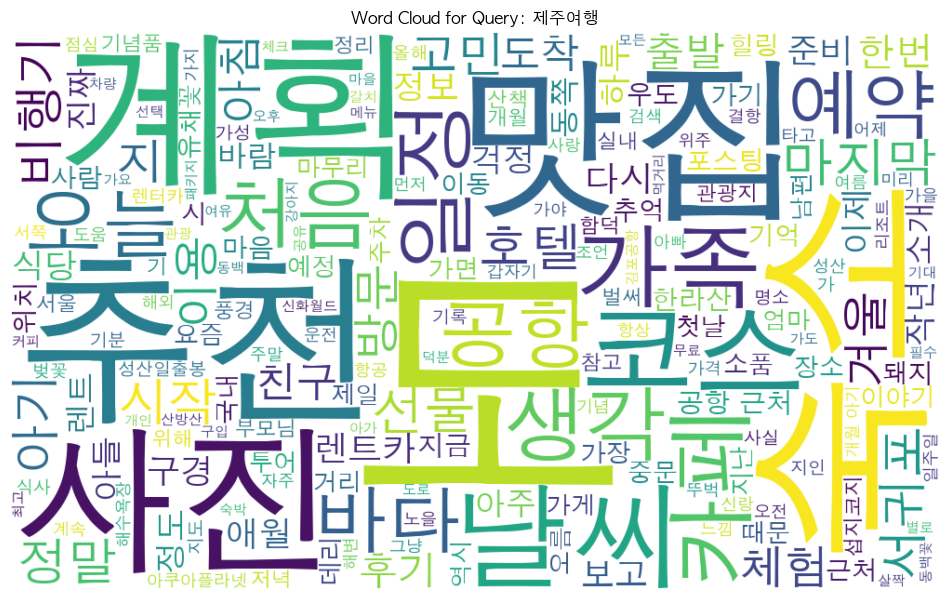

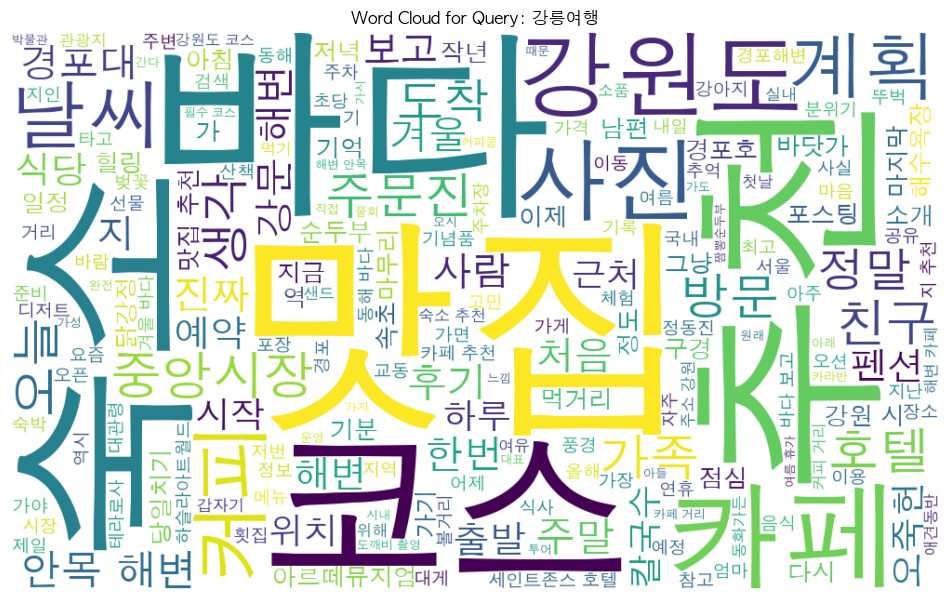

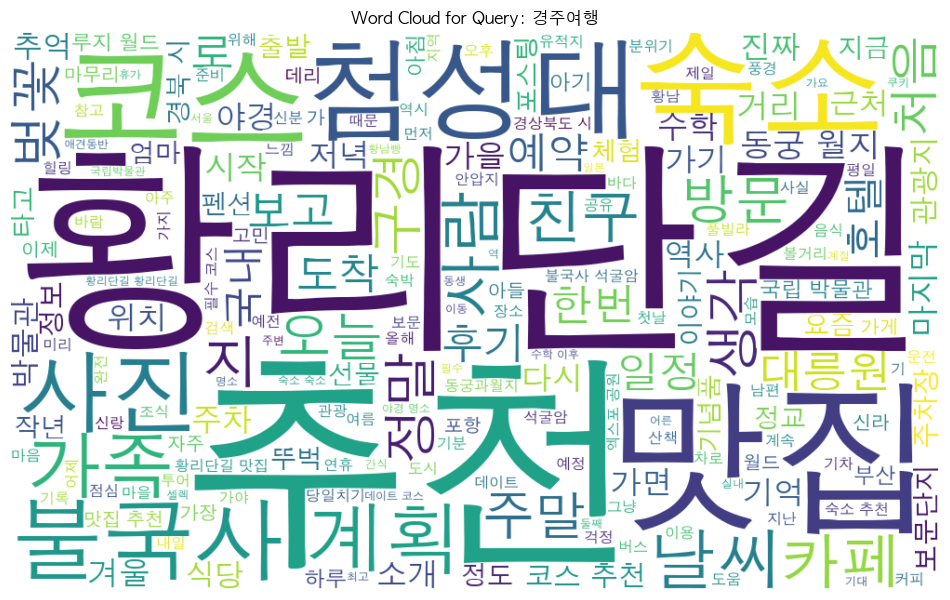

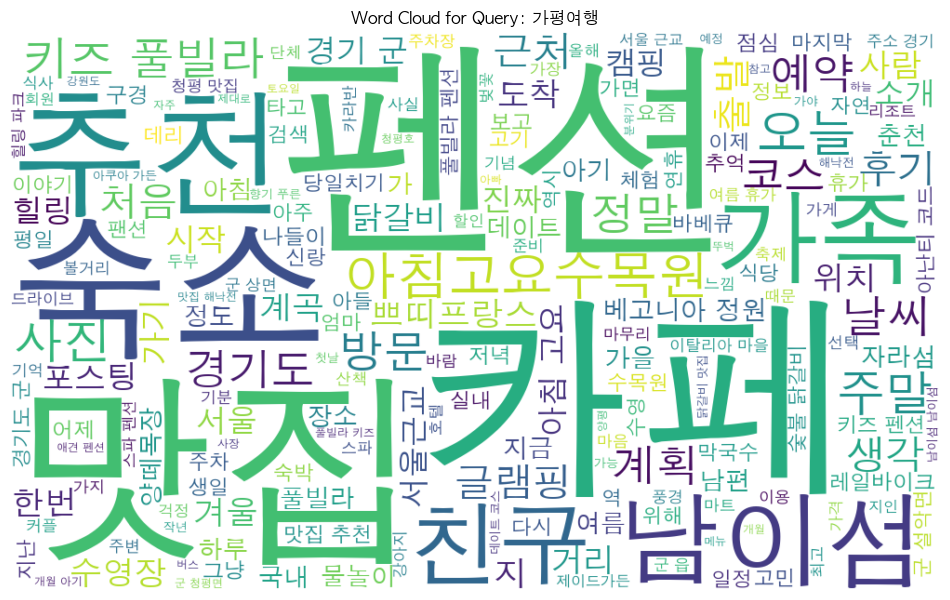

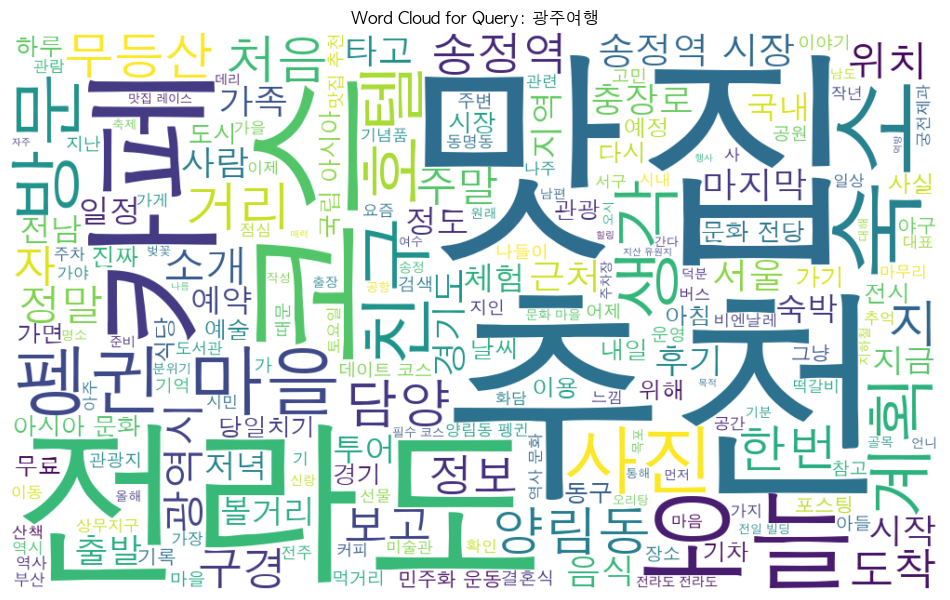

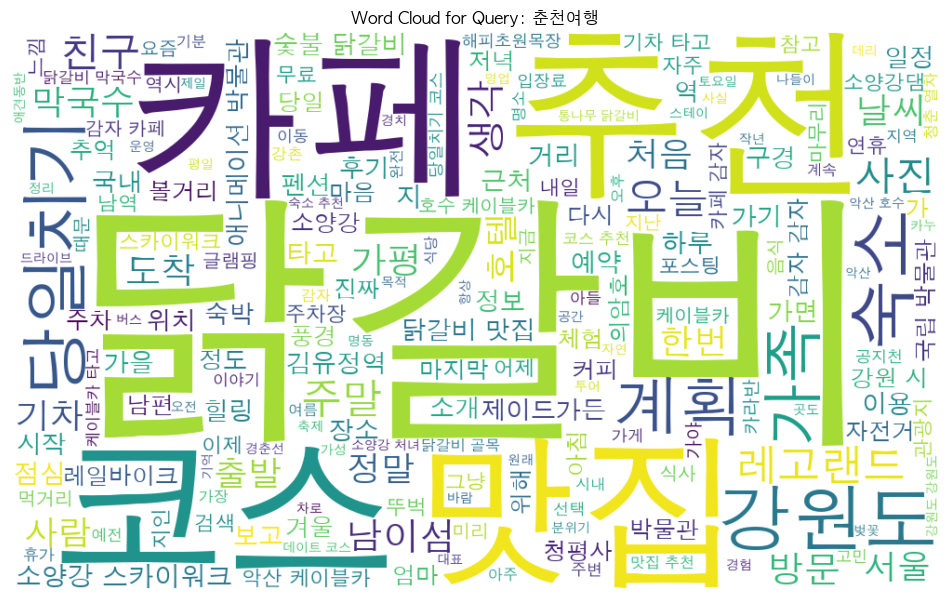

In [10]:
# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 쿼리별로 텍스트를 모아서 하나의 텍스트로 만들어 워드클라우드 생성
queries = df_travel['query'].unique()
for query in queries:
    # 해당 쿼리에 해당하는 행만 추출하여 텍스트 합치기
    tokens = df_travel[df_travel['query'] == query]['tokens']
    text = ' '.join(word for sublist in tokens for word in sublist if len(word) > 1)
    
    # 쿼리명에서 '여행' 등의 공통 단어 제거
    for word in query.split('여행'):
        text = text.replace(word, '')

    # '여행' 단어 제거
    text = text.replace('여행', '')

    # 워드클라우드 생성
    wordcloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf', background_color='white', width=1000, height=600).generate(text)

    # 워드클라우드 시각화
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Query: {query}')
    plt.axis('off')
    plt.show()



# LDA

In [12]:
# CSV 파일을 읽어옵니다.
df_travel_tokens = pd.read_csv('text_data_project_tokens_2.csv')

# 토큰이 담긴 컬럼을 리스트로 변환합니다.
df_travel_tokens['tokens'] = df_travel_tokens['tokens'].apply(eval)

# 한글자 이하 단어를 제거하는 함수
def remove_short_tokens(tokens):
    return [token for token in tokens if len(token) > 1]

# 토큰 리스트에서 한글자 이하 단어를 제거합니다.
df_travel_tokens['tokens'] = df_travel_tokens['tokens'].apply(remove_short_tokens)

# 쿼리별로 데이터를 그룹화합니다.
grouped = df_travel_tokens.groupby('query')

# 각 쿼리에 대해 LDA 모델을 훈련하고 시각화합니다.
for query, group in grouped:
    print(f"Processing query: {query}")

    # 토큰 리스트 생성
    tokens = group['tokens'].tolist()

    # 단어 사전을 생성합니다.
    dictionary = corpora.Dictionary(tokens)

    # 말뭉치를 생성합니다.
    corpus = [dictionary.doc2bow(text) for text in tokens]

    # LDA 모델을 훈련합니다.
    lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=50)

    # 토픽 모델링 결과를 시각화합니다.
    lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

    # 시각화를 주피터 노트북에 표시합니다.
    display(pyLDAvis.display(lda_vis))




Processing query: 가평여행


Processing query: 강릉여행


Processing query: 경주여행


Processing query: 광주여행


Processing query: 부산여행


Processing query: 여수여행


Processing query: 제주여행


Processing query: 춘천여행
